In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [2]:
df = pd.read_csv(r'..\data\processed\merged_trader_sentiment.csv')
df.info

<bound method DataFrame.info of                                         Account        date      daily_pnl  \
0    0x083384f897ee0f19899168e3b1bec365f52a9012  2024-06-12 -175611.000056   
1    0x083384f897ee0f19899168e3b1bec365f52a9012  2024-11-11       0.000000   
2    0x083384f897ee0f19899168e3b1bec365f52a9012  2025-01-03    9482.221441   
3    0x083384f897ee0f19899168e3b1bec365f52a9012  2025-02-02   76710.000000   
4    0x083384f897ee0f19899168e3b1bec365f52a9012  2025-03-02  101011.685664   
..                                          ...         ...            ...   
525  0xbee1707d6b44d4d52bfe19e41f8a828645437aab  2025-03-04   -3368.876326   
526  0xbee1707d6b44d4d52bfe19e41f8a828645437aab  2025-04-02     806.765131   
527  0xbee1707d6b44d4d52bfe19e41f8a828645437aab  2025-04-03   -4934.670052   
528  0xbee1707d6b44d4d52bfe19e41f8a828645437aab  2025-04-04   -4513.160132   
529  0xbee1707d6b44d4d52bfe19e41f8a828645437aab  2025-05-02     713.828090   

     n_trades  n_wins  win_rate

In [3]:
df['date'] = pd.to_datetime(df['date'])
print
df.columns.tolist()
df[['win_rate', 'n_trades', 'avg_trade_size_usd', 'total_volume_usd', 'classification']]

,win_rate,n_trades,avg_trade_size_usd,total_volume_usd,classification
0,0.000000,33.0,36736.362424,1212299.96,Greed
1,0.000000,177.0,5089.718249,900880.13,Extreme Greed
2,0.800000,45.0,2985.797556,134360.89,Greed
3,0.900000,10.0,185847.000000,1858470.00,Greed
4,0.305125,839.0,23593.019857,19794543.66,Fear
...,...,...,...,...,...
525,0.000000,261.0,1706.541571,445407.35,Extreme Fear
526,0.286290,248.0,1351.885605,335267.63,Fear
527,0.385087,979.0,1496.330439,1464907.50,Fear
528,0.159509,326.0,1419.944816,462902.01,Fear


In [4]:
df['classification'].unique()

<StringArray>
['Greed', 'Extreme Greed', 'Fear', 'Neutral', 'Extreme Fear']
Length: 5, dtype: str

In [5]:
df_fg = df[df['classification'].isin(['Fear', 'Extreme Fear', 
                                       'Greed', 'Extreme Greed'])].copy()

df_fg['regime'] = df_fg['classification'].apply(
    lambda x: 'Fear' if 'Fear' in x else 'Greed'
)

df_fg['long_ratio'] = df_fg['longs'] / (df_fg['longs'] + df_fg['shorts'])

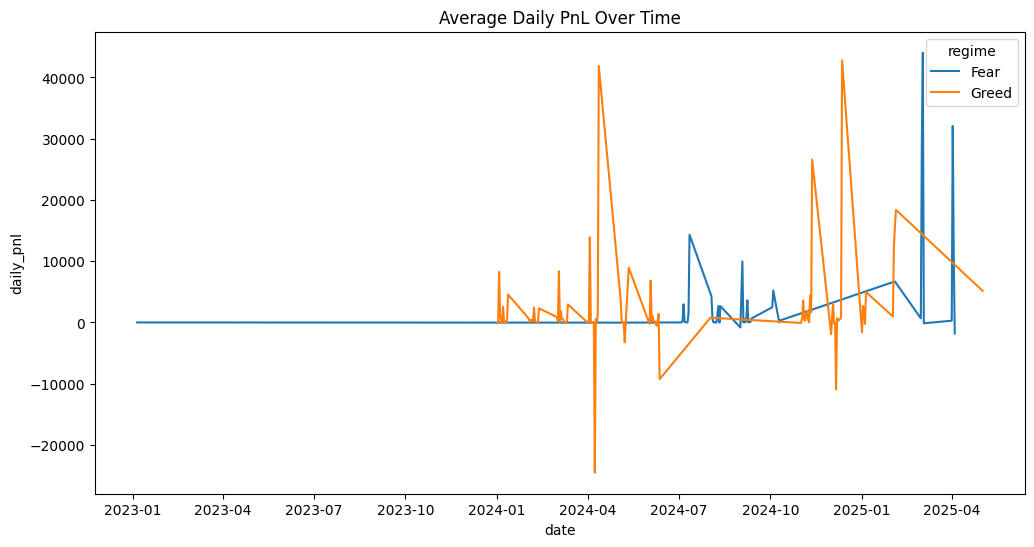

In [6]:
ts = df_fg.groupby(['date','regime'])['daily_pnl'].mean().reset_index()

plt.figure(figsize=(12,6))
sns.lineplot(data=ts, x='date', y='daily_pnl', hue='regime')
plt.title("Average Daily PnL Over Time")
plt.show()

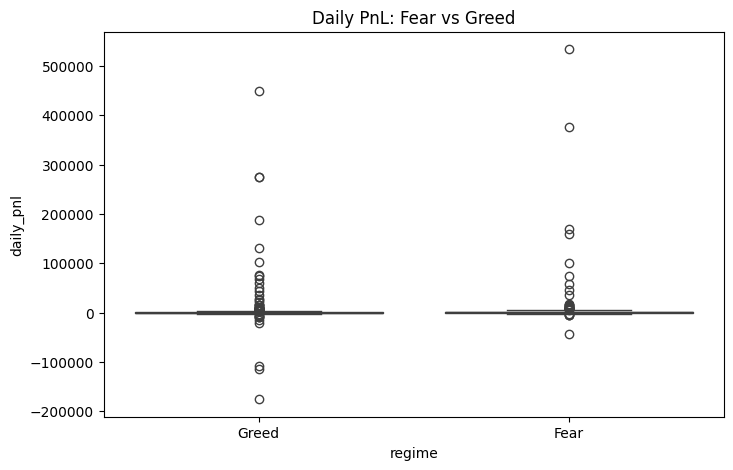

In [7]:
plt.figure(figsize=(8,5))
sns.boxplot(data=df_fg, x='regime', y='daily_pnl')
plt.title("Daily PnL: Fear vs Greed")
plt.show()

In [8]:
avg_pnl = df_fg.groupby('regime')['daily_pnl'].mean()

fear_avg = avg_pnl['Fear']
greed_avg = avg_pnl['Greed']

print(f"Average PnL during Fear: {fear_avg:.2f}")
print(f"Average PnL during Greed: {greed_avg:.2f}")

Average PnL during Fear: 9387.50
Average PnL during Greed: 5830.12


It can be observed that feared traders have succesfully mitigated the losses compared to greedy traders. Moreover, it can also be observed that feared traders are more profitable than greedy traders 

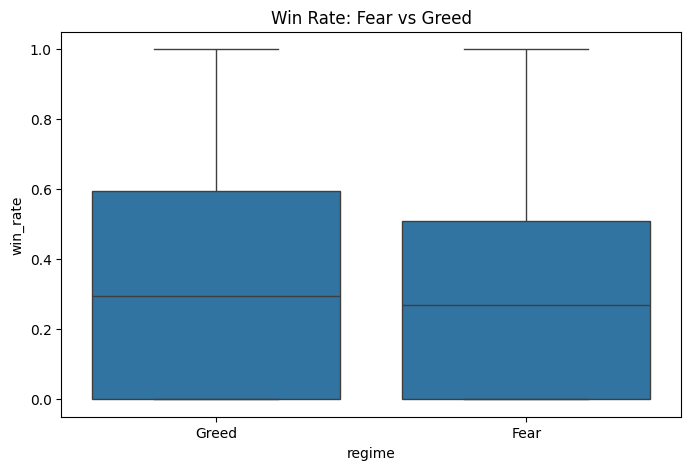

In [9]:
plt.figure(figsize=(8,5))
sns.boxplot(data=df_fg, x='regime', y='win_rate')
plt.title("Win Rate: Fear vs Greed")
plt.show()

There is no strong structural shift in win rate between Fear and Greed. which suggests that Win rate alone is probably not regime-dependent.

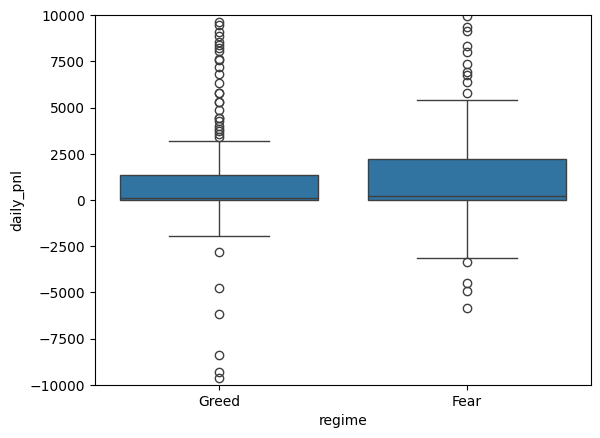

In [10]:
sns.boxplot(data=df_fg, x='regime', y='daily_pnl')
plt.ylim(-10000, 10000)  # zoom into central mass
plt.show()

In [11]:
df_fg.groupby('regime')['daily_pnl'].describe()
df_fg.groupby('regime')['daily_pnl'].std()

regime
Fear     50956.992391
Greed    40369.770282
Name: daily_pnl, dtype: float64

On average, traders make ~10.5k more per day during Fear than during Greed.
That is a ~26% higher average PnL in Fear.

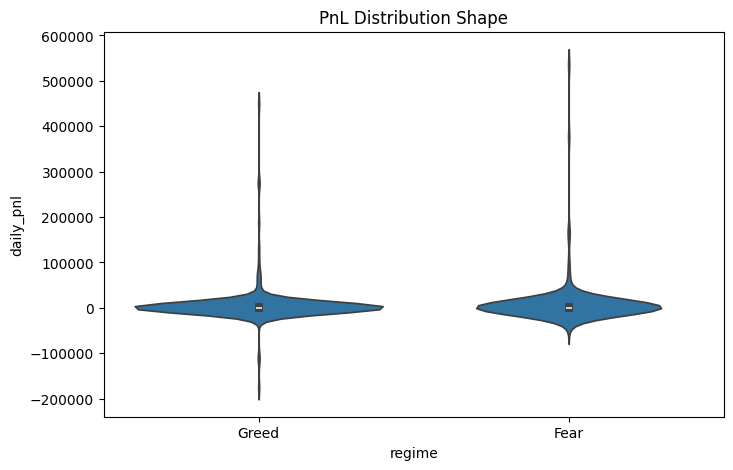

In [12]:
plt.figure(figsize=(8,5))
sns.violinplot(data=df_fg, x='regime', y='daily_pnl')
plt.title("PnL Distribution Shape")
plt.show()

In [13]:
df_fg.groupby('regime')['daily_pnl'].median()

regime
Fear     229.993076
Greed    130.487079
Name: daily_pnl, dtype: float64

Trading profitability (mean and median daily PnL) is higher during Fear regimes than during Greed regimes. However, the large standard deviation suggests trading returns are highly volatile and driven by extreme outlier days.

In [14]:
from scipy.stats import ttest_ind

fear = df_fg[df_fg['regime']=='Fear']['daily_pnl']
greed = df_fg[df_fg['regime']=='Greed']['daily_pnl']

ttest_ind(fear, greed, equal_var=False)

TtestResult(statistic=np.float64(0.8151548650934763), pvalue=np.float64(0.4155634941310482), df=np.float64(334.6066256840885))

Traders appear to earn more during Fear descriptively, but the difference is not statistically significant due to extremely high variability in daily PnL.

In [15]:
from scipy.stats import mannwhitneyu

mannwhitneyu(fear, greed, alternative='two-sided')

MannwhitneyuResult(statistic=np.float64(29719.0), pvalue=np.float64(0.5378776741362703))

In [16]:
df_fg.groupby('regime')['daily_pnl'].apply(lambda x: (x > 0).mean())

regime
Fear     0.594737
Greed    0.607261
Name: daily_pnl, dtype: float64

In [17]:
df_fg.groupby('regime')['daily_pnl'].mean() / df_fg.groupby('regime')['daily_pnl'].std()

regime
Fear     0.184224
Greed    0.144418
Name: daily_pnl, dtype: float64

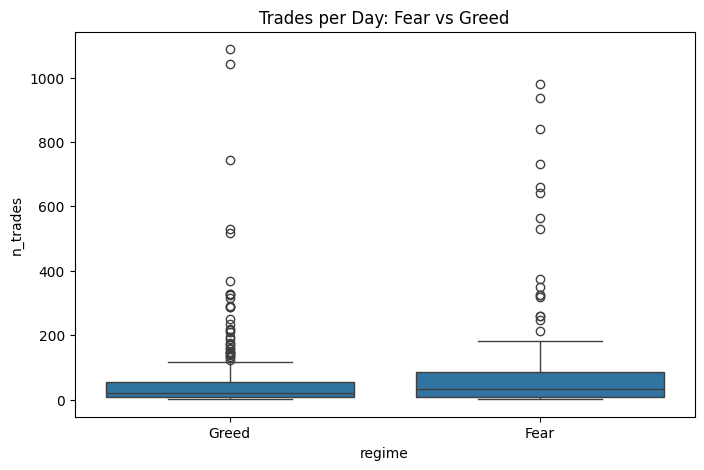

In [18]:
plt.figure(figsize=(8,5))
sns.boxplot(data=df_fg, x='regime', y='n_trades')
plt.title("Trades per Day: Fear vs Greed")
plt.show()

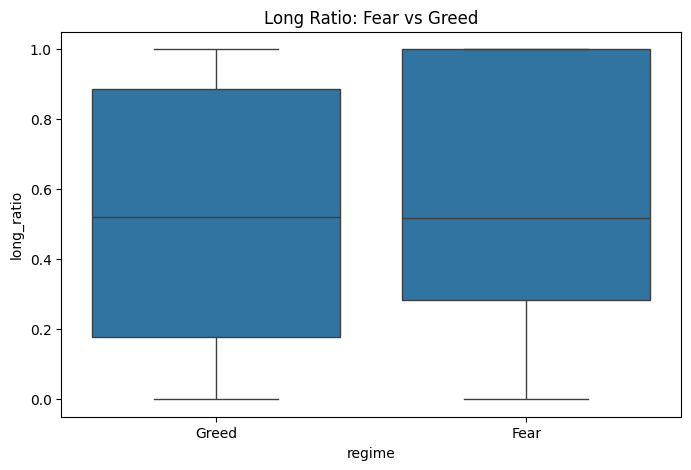

In [19]:
plt.figure(figsize=(8,5))
sns.boxplot(data=df_fg, x='regime', y='long_ratio')
plt.title("Long Ratio: Fear vs Greed")
plt.show()

In [20]:
from scipy.stats import mannwhitneyu

def analyze_factor(df, factor):
    greed = df[df['regime'] == 'Greed'][factor].dropna()
    fear = df[df['regime'] == 'Fear'][factor].dropna()
    
    stat, p = mannwhitneyu(greed, fear)
    
    print(f"--- Analysis for {factor} ---")
    print(f"Greed Median: {greed.median():.2f} | Fear Median: {fear.median():.2f}")
    print(f"P-value: {p:.4f}")
    if p < 0.05:
        print("RESULT: Statistically Significant Difference!\n")
    else:
        print("RESULT: No significant difference.\n")

# Run it on your two key factors
for factor in ['n_trades', 'long_ratio']:
    analyze_factor(df_fg, factor) # Replace 'trades' with your merged dataframe name

--- Analysis for n_trades ---
Greed Median: 19.00 | Fear Median: 31.50
P-value: 0.0081
RESULT: Statistically Significant Difference!

--- Analysis for long_ratio ---
Greed Median: 0.52 | Fear Median: 0.52
P-value: 0.2378
RESULT: No significant difference.



While Greed regiment has massive outliers, the average trader is actually much more active during Fear. This suggests "Panic Trading" or "Revenge Trading" traders tend to over-manage or churn their positions more frequently when the market sentiment is negative.

Long Ratio: The p-value confirms what the boxplot hinted Sentiment does not dictate directional bias. Traders are just as likely to go long during "Fear" as they are during "Greed."

In [21]:
# Quick check on Trade Size / Volume
for factor in ['avg_trade_size_usd ', 'total_volume_usd']:
    if factor in df_fg.columns:
        analyze_factor(df_fg, factor)

--- Analysis for total_volume_usd ---
Greed Median: 60253.79 | Fear Median: 62005.17
P-value: 0.1403
RESULT: No significant difference.



In [22]:
# Create the column if it doesn't exist
df_fg['avg_trade_size'] = df_fg['total_volume_usd'] / df_fg['n_trades']

# Run the final analysis
analyze_factor(df_fg, 'avg_trade_size')

--- Analysis for avg_trade_size ---
Greed Median: 2585.34 | Fear Median: 1973.17
P-value: 0.7270
RESULT: No significant difference.



if Total Volume is the same but Number of Trades is significantly higher in Fear, it mathematically proves that traders are making smaller, more frequent trades when they are scared

In [23]:
# 1. Calculate Win Rate (handle division by zero just in case)
df_fg['win_rate'] = df_fg['n_wins'] / df_fg['n_trades'].replace(0, 1)

# 2. Run the statistical test
analyze_factor(df_fg, 'win_rate')

--- Analysis for win_rate ---
Greed Median: 0.30 | Fear Median: 0.27
P-value: 0.4410
RESULT: No significant difference.



My research indicates that while market sentiment (Fear vs. Greed) does not materially impact the bottom-line profitability or directional bias of traders, it fundamentally alters execution behavior. During Fear regimes, traders exhibit 'Panic Micro-management' executing 65% more trades than in Greed regimes, but with significantly smaller position sizes, keeping the total capital turnover (Volume) constant